## **Notebook Content**

Project: *Customer Prioritization Under Constraints*

File: 03_dimensionality_reduction.ipynb <br>
Author: Bryan Melvida

Purpose:
- Assess whether dimensionality reduction is suitable for the engineered behavioral feature space prior to clustering
- Check how variance-based transformations affect behavioral structure and separation
- Decide whether to retain the scaled base feature space for downstream segmentation

Input: [`customer_features.parquet`](../data/preprocessed/customer_features.parquet) <br>

Output: [`scaled_customer_features.parquet`](../data/preprocessed/scaled_customer_features.parquet)<br>
Related Documentation:

<br>

---

<br>


In [1]:
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
from pathlib import Path

import sys
sys.path.append('../')
import src.assessment_views as av
from src import plot_settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plot_settings.set()

In [2]:
customer_features = pd.read_parquet('../data/preprocessed/customer_features.parquet', engine= 'pyarrow')
df_features = customer_features[customer_features.columns.difference(['CustomerID'])]

<br>

---

## **Feature Set Freeze Confirmation**

Locks the feature set for dimensionality reduction

<br>

| Feature Name | Behavioral Dimension | Accumulation Profile |
| --- | --- | --- |
| cancellation_rate | Stability | Rate / Normalized |
| product_repeat_rate | Repeat Behavior | Rate / Normalized |
| total_transaction | Persistence | Lifecycle-Accumulating |
| n_unique_purchased_product | Complexity | Lifecycle-Accumulating |
| avg_order_value | Efficiency | Transaction-Conditioned |
| avg_days_between_purchases | Rhythm | Transaction-Conditioned |
| days_since_last_purchase | Timing | State-Based |
| is_seasonal | Temporal Concentration | State-Based |
| is_uk_customer | Operational Context | Contextual |

<br>
<br>

---

## **Pre Dimensionality Reduction Variance Diagnostics**

Identifies dominant variance drivers prior to transformation to flag features that may overwhelm behavioral structure for non-behavioral reasons

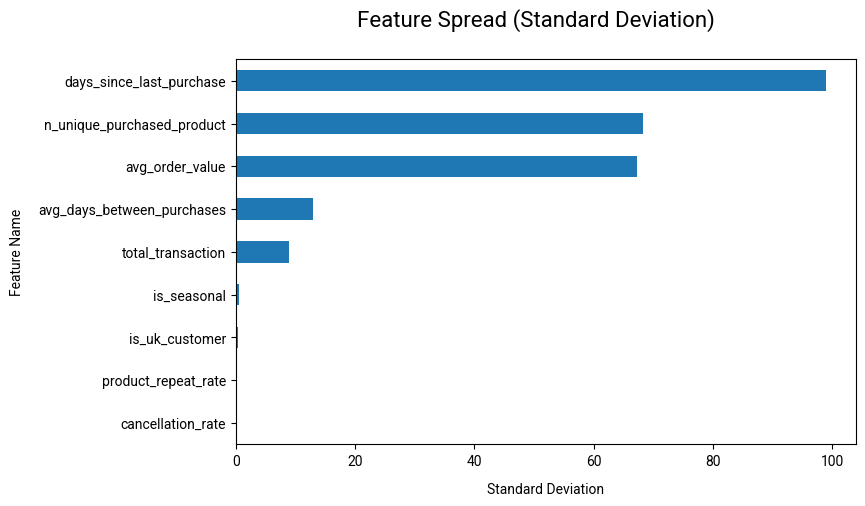

In [3]:
plt.figure(figsize=(8,5))
plt.suptitle("Feature Spread (Standard Deviation)")

feature_spread = df_features.std().sort_values()
feature_spread.plot(kind= 'barh')

plt.xlabel("Standard Deviation")
plt.ylabel("Feature Name")

plt.show()

>- Variance is highest in features based on counts, time gaps, and spend
>- No features show variance issues that require correction at this stage

<br>

---

## **Feature Correlation Analysis**

Correlation is evaluated in the context of behavioral features:
- expected given accumulation and exposure effects
- reflects coupled behavioral patterns
- informs how features may aggregate under variance-based methods

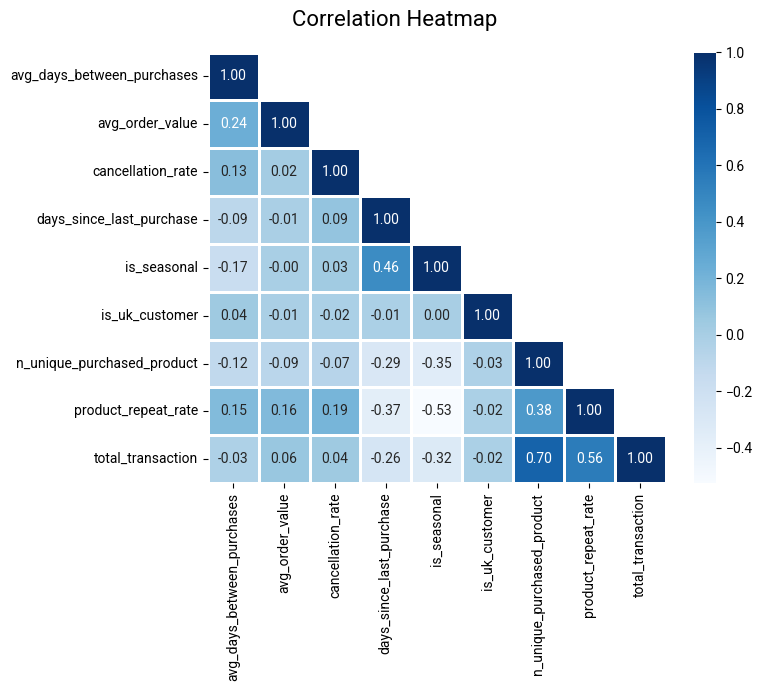

In [4]:
corr_features = df_features.corr()

plt.figure(figsize= (8,7))
plt.suptitle('Correlation Heatmap')

mask = np.zeros_like(corr_features)
mask[np.triu_indices_from(mask, k=1)] = True

sns.heatmap(data= corr_features,
            mask= mask,
            annot= True,
            fmt= '.2f',
            linewidths= 1,
            cmap= 'Blues')

plt.tight_layout()
plt.show()

>- Correlation analysis reveals expected alignment among persistence, repeat behavior, and number of unique products purchased.
>
>- Strong correlation between total transactions and number of unique products indicates that these features capture overlapping exposure effects and may aggregate under variance-based transformations.
>
>- No correlations suggest feature leakage or invalid behavioral encoding.

<br>

---

## **Feature Scaling**

Scales features to normalize influence

In [5]:
scaler = StandardScaler()

# exclude binary features
excluded_features = df_features.columns.difference(['is_seasonal', 'is_uk_customer'])
scaled_customer_features = customer_features.copy()

scaled_customer_features[excluded_features] = scaler.fit_transform(customer_features[excluded_features])
scaled_customer_features.set_index('CustomerID',inplace= True)

scaled_customer_features.head()

,cancellation_rate,days_since_last_purchase,total_transaction,avg_order_value,avg_days_between_purchases,n_unique_purchased_product,product_repeat_rate,is_seasonal,is_uk_customer
CustomerID,,,,,,,,,
17850,0.042492,2.144125,3.356608,-0.099882,-0.292120,-0.517984,4.222300,1,1
13047,0.816854,-0.584533,1.458266,-0.153049,-0.154331,0.521420,1.600167,0,1
12583,-0.209444,-0.877611,1.346598,0.031304,-0.197552,0.770292,2.137275,0,0
13748,-0.313296,0.062260,0.006592,0.190734,0.806106,-0.459426,-0.325030,0,1
15291,0.277860,-0.645170,1.569933,0.264733,0.017316,-0.049520,1.409081,0,1


<br>

---

## **Dimensionality Reduction (PCA)**

Compresses behavioral structure for downstream analysis

In [6]:
pca = PCA().fit(X= scaled_customer_features)
feature_names = scaled_customer_features.columns.tolist()

# Extract PCA loadings to evaluate behavioral meaning of components
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_names,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Inspect early components that drive most of the separation
loadings.iloc[:, :3].abs().round(2)

,PC1,PC2,PC3
cancellation_rate,0.04,0.38,0.81
days_since_last_purchase,0.37,0.02,0.41
total_transaction,0.55,0.11,0.14
avg_order_value,0.06,0.53,0.31
avg_days_between_purchases,0.05,0.64,0.20
n_unique_purchased_product,0.51,0.31,0.05
product_repeat_rate,0.51,0.23,0.12
is_seasonal,0.18,0.03,0.08
is_uk_customer,0.00,0.00,0.01


**Acceptance Rule**
- Dimensionality reduction is acceptable only if early components are driven by clear behavioral dimensions aligned with the base feature intent and meaningfully affect separation
- If early components are driven by lifecycle, exposure, or mixed signals, dimensionality reduction is rejected, even if later components appear interpretable

`PC1 Features`
- total_transaction (0.55)
- product_repeat_rate (0.51)
- n_unique_purchased_product (0.51)
- days_since_last_purchase (0.37)
- is_seasonal (0.18)

>PC1 mainly separates customers by transaction volume and tenure, combining total transactions, product repetition, and product exposure, with recency offsetting the effect
>
> This component reflects accumulated lifecycle exposure rather than a distinct behavioral dimension, collapsing multiple intended behaviors into a single axis

<br>

`PC2 Features`
- avg_days_between_purchases (0.64)
- avg_order_value (0.53)
- cancellation_rate (0.38)
- n_unique_purchased_product (0.31)


>PC2 groups unrelated behaviors, including purchase timing, order value, and cancellation activity
>
>These features do not reflect a shared behavioral pattern and appear grouped due to variance alignment rather than behavioral meaning, resulting in a component that is not interpretable

<br>

`PC3 Features`
- cancellation_rate (0.81)
- days_since_last_purchase (0.41)
- avg_order_value (0.31)

>PC3 captures cancellation-related stability behavior, with secondary influence from recency and order value
>
>While interpretable on its own, this component appears after lifecycle-driven components and therefore has limited impact on distance and clustering outcomes

<br>

---


## **Dimensionality Reduction Decision**

>- PCA components are driven by lifecycle and exposure features, collapsing multiple behavioral dimensions early
>- Key behavioral constructs (rhythm, efficiency, stability) do not remain distinct after reduction
>- PCA is rejected. Clustering will proceed on the scaled base feature space.

<br>

---

In [7]:
scaled_customer_features.to_parquet('../data/preprocessed/scaled_customer_features.parquet', engine= 'pyarrow')

## **End of Notebook**

* Assessed dimensionality reduction suitability prior to clustering
* PCA rejected due to early components being driven by lifecycle and exposure effects rather than coherent behavioral structure
* The scaled base feature set will be used for downstream analysis
* Ready for downstream notebook: [`04_clustering_analysis.ipynb`](../notebooks/04_clustering_analysis.ipynb)